# 0.0 Modules, etc.

In [2]:
import numpy as np
import pandas as pd
import multiprocessing

import scipy
from scipy import spatial
from scipy.spatial import cKDTree

import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import clone
from sklearn.externals.six.moves import xrange

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

Loading BokehJS ...

In [ ]:
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 5000)

In [ ]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='duplinskiy', api_key='RsZHhxIiAGGu7FN9P4bu')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

cf.go_offline()

# 1 Preprocessing

## 1.1 Wrangling

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

dat = dat0.copy()

dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names

dat = dat[dat['gross_demand_quantity'] != 0] 

Data

    (0) dat0
    (1) dat

In [ ]:
# Feature subset for clustering

dat = dat[['article_number', 
           'gross_demand_quantity', # mean, sum, std
           'fraction_of_full_price', # mean, std
           'markdown', # mean (INDICATOR) 
           'sale', # mean (INDICATOR no/sale)
           'gross_sales_net_disc_gross_ret']]

dat['sales_price'] = dat['gross_sales_net_disc_gross_ret'].divide(dat['gross_demand_quantity'])
dat.drop('gross_sales_net_disc_gross_ret', axis = 1, inplace = True)

In [ ]:
%%time

dat_grouped = dat.groupby(by = 'article_number')

dat = dat_grouped.agg(['mean', 'std']) # Need count
dat.drop([('markdown', 'std'),('sale', 'std')], axis = 1, inplace=True)
dat[('gross_demand_quantity','sum')] = dat_grouped['gross_demand_quantity'].sum()

dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
dat = dat.replace([np.inf, -np.inf, np.nan], 0)

## 1.2 Save/Load curated data

In [ ]:
# Save/load tidied version

# dat.to_csv('dat.csv')

dat = pd.read_csv('dat.csv', low_memory=False, index_col = 0, header = [0,1]) # gotta encode multi-index

# 2 Clustering 

## 2.0 Baseline: feature-based

### 2.0.1 Sort

In [ ]:
feature = 'sales_price'
stat = 'mean'

dat_feature_sorted = dat.sort_values([(feature, stat)], ascending=False) # Sort

# # --- Feature cumulative sum ---
# dat_feature_sorted['cumulative_feature'] = dat_feature_sorted[feature][stat].cumsum()

# # --- Feature cumulative percent ---
# total = dat_feature_sorted[feature][stat].sum() 
# dat_feature_sorted['cumulative_pct_feature'] = dat_feature_sorted[feature][stat].cumsum()/total

# # --- Cumulative percent of articles ---
# t = pd.Series(range(1, 46573))/46572
# dat_feature_sorted['cumulative_pct_articles'] = t.values

# --- Add feature based cluster; i.e. top X are labelled non-basic ---
f = pd.DataFrame(np.concatenate([np.ones(8483), np.zeros(38089)]))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(dat_feature_sorted)
dat_feature_sorted_scaled = scaler.transform(dat_feature_sorted)

pca = PCA(n_components=2) # keep the first two principal components of the data
pca.fit(dat_feature_sorted_scaled)

# transform data onto the first two principal components
dat_pca = pd.DataFrame(pca.transform(dat_feature_sorted_scaled))


### 2.0.2 Plot

In [ ]:
plt.rcParams["figure.figsize"] = [16,5]

plt.scatter(dat_pca[0], 
            dat_pca[1], 
            c = f[0],
            alpha = 0.5)

plt.colorbar()

plt.title('Basic and Non-basic')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')


In [ ]:
plt.plot(dat_feature_sorted['cumulative_pct_articles'], 
         dat_feature_sorted['cumulative_pct_feature'],
        linewidth = 3)

# plt.xlabel('Percent of Articles')
# plt.ylabel('Percent of Feature of Interst')

plt.rcParams["figure.figsize"] = [6,6]
plt.title('Majority, from a Minority of Articles')

In [ ]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = dat_feature_sorted['cumulative_pct_articles'],
    y = dat_feature_sorted['cumulative_pct_feature'],
    mode = 'lines',
    name = '45 degree line'
)


data = [trace1]
iplot(data, filename='scatter-mode')

## 2.01 Scale (for ML approaches)

In [ ]:
# SCALING: zero mean and unit variance 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dat)
dat_scaled = pd.DataFrame(scaler.transform(dat), columns = dat.columns, index = dat.index)

## 2.1 k-means

### 2.1.1 Model

In [ ]:
%%time

# K-means clustering  --------------------  --------------------
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(dat_scaled)

Kmeans = pd.Series(kmeans.predict(dat_scaled)) # Cluster assignments

# Cluster counts
print(Kmeans.value_counts())
print()

In [ ]:
Kmeans = (Kmeans != 0)*1 # lone vector
Kmeans.value_counts()

# k = pd.DataFrame({'kmeans': Kmeans.values}, index = dat_scaled.index)


### 2.1.2 Plots

In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
pd.plotting.scatter_matrix(
    dat[[
        ('gross_demand_quantity', 'mean'), 
        ('gross_demand_quantity', 'std'),
        ('sales_price', 'mean'), 
        ('gross_demand_quantity', 'sum')
        ]], 
    figsize=(10,10),
    diagonal='kde',
    c = Kmeans, 
    alpha = 0.5
)

In [ ]:
plt.subplot(2, 1, 1)
plt.scatter(dat['gross_demand_quantity']['mean'], 
            dat['sales_price']['mean'], 
            c = Kmeans,
            alpha = 0.5)
plt.title('Sale Price vs. Gross Demand Quantity')
plt.ylabel('Sale Price')

plt.subplot(2, 1, 2)
plt.scatter(dat['gross_demand_quantity']['sum'], 
            dat['sales_price']['mean'], 
            c = Kmeans,
            alpha = 0.5)
# plt.title('Sale Price vs. Gross Demand Qty (mean/sum)')
plt.ylabel('Sale Price')
plt.xlabel('GDQ Sum')

# plt.xlabel('Sales Price')
# plt.ylabel('log(sold_qty)')

# plt.colorbar()
# plt.rcParams["figure.figsize"] = [5,5]
# plt.title('K-means Classification')


### 2.1.3 Histograms

In [ ]:
#### (a) gross_demand_quantity - basic

# Histogram: total gross demand quantity, basic items
dat[(dat['Kmeans'] == 0) & (dat['gross_demand_quantity']['sum'] < 10000)]['gross_demand_quantity']['sum'].hist(bins = 100)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')

#### (b) gross_demand_quantity - non-basic

# Histogram: total gross_demand_quantity, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['gross_demand_quantity']['sum'] < 5000)]['gross_demand_quantity']['sum'].hist(bins = 50)

plt.xlabel('Total Gross Demand Quantity')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')


#### (c) sales_price - basic

# Histogram: sales_price, basic items
dat[(dat['Kmeans'] == 0) & (dat['sales_price']['mean'] < 200) & (dat['sales_price']['mean'] > 0)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Basic Articles')


#### (d) sales_price - non-basic

# Histogram: sales_price, non-basic items
dat[(dat['Kmeans'] != 0) & (dat['sales_price']['mean'] < 200)]['sales_price']['mean'].hist(bins = 100)

plt.xlabel('Sale Price')
plt.ylabel('Quantity')

plt.rcParams["figure.figsize"] = [12,12]
plt.title('Non-basic Articles')

## 2.2 Agglomerative Clustering

In [ ]:
%%time

# Agglomerative Clustering -------------
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters = 6)
agglom = pd.Series(agg.fit_predict(dat_scaled))

agglom.value_counts()

In [ ]:
# # Reclassify: majority/non as 0/1 

agglom = (agglom != 0)*1 # lone vector
agglom.value_counts()

In [ ]:
a = pd.DataFrame({'agglom': agglom.values}, index = dat_scaled.index)

In [ ]:
plt.subplot(2, 1, 1)
plt.scatter(dat_scaled['gross_demand_quantity']['mean'], 
            dat_scaled['sales_price']['mean'], 
            c = agglom,
            alpha = 0.25)
plt.title('Agglomerative Classes: Sale Price vs. Gross Demand Qty (mean/sum)')
plt.ylabel('Sale Price')

plt.subplot(2, 1, 2)
plt.scatter(dat_scaled['gross_demand_quantity']['sum'], 
            dat_scaled['sales_price']['mean'], 
            c = agglom,
            alpha = 0.25)
plt.ylabel('Sale Price')
plt.xlabel('GDQ Sum')


## 2.3 DBSCAN 

'density based spatial clustering of applications with noise'

In [ ]:
%%time

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.145, min_samples = 5) # 3min 36s
dbs = pd.Series(dbscan.fit_predict(dat_scaled))

In [ ]:
dbs.value_counts()

In [ ]:
# # Reclassify: majority/non as 0/1 
dbs01 = (dbs == -1)*1 # lone vector
dbs01.value_counts()

In [ ]:
dbs = pd.DataFrame({'dbs': dbs01.values}, index = dat_scaled.index)

In [ ]:
plt.scatter(np.log(dat['net_sales']['sum']), 
            np.log(dat['sold_qty']['sum']), 
            c = dbs01,
            alpha = 0.15)
plt.xlabel('log(net_sales)')
plt.ylabel('log(sold_qty)')
plt.colorbar()
plt.title('DBSCAN Classification')
plt.rcParams["figure.figsize"] = [16,16]

## 2.4 Evaluation

### 2.4.1 Cross methods comparison

In [ ]:
# k_a = pd.merge(k, a, left_index = True, right_index = True)
# f_k_a = pd.merge(f, k_a, left_index=True, right_index=True)
# fka_dbs = pd.merge(f_k_a, dbs, left_index=True, right_index=True)

In [ ]:
# .groupby(['feat_based', 'kmeans', 'agglom']).size()

# table = pd.DataFrame(data = {'Ag': agglom, 'Km': Kmeans, 'DB': dbs01})
# table.groupby(['Ag', 'Km', 'DB']).size()
1 - 3924/46573 # 0.9157 kmeans-agglomerative agreement


### 2.4.2 Clustering Metrics

See https://scikit-learn.org/stable/modules/clustering.html for metric information (2.4.2 - __ )

In [ ]:
dat_feature_sorted_scaled = pd.DataFrame(StandardScaler().fit(dat_feature_sorted).transform(dat_feature_sorted), 
                                         columns = dat_feature_sorted.columns,
                                         index = dat_feature_sorted.index)


#### Silhouette Coefficient

In [ ]:
from sklearn import metrics

# higher better

metrics.silhouette_score(dat_feature_sorted_scaled, f['feat_based']) # feature based: 0.555

metrics.silhouette_score(dat_feature_sorted, f['feat_based']) # feature based: 0.59568
metrics.silhouette_score(dat_scaled, k['kmeans']) # k-means: 0.44598
metrics.silhouette_score(dat_scaled, a['agglom']) # agglomerative: 0.33
metrics.silhouette_score(dat_scaled, dbs['dbs']) # DBSCAN: 0.25


#### Calinski-Harabaz Index

In [ ]:
# higher better

metrics.calinski_harabaz_score(dat_feature_sorted_scaled, f['feat_based']) # 20816

metrics.calinski_harabaz_score(dat_feature_sorted, f['feat_based']) # 77433
metrics.calinski_harabaz_score(dat_scaled, k['kmeans']) # 7474
metrics.calinski_harabaz_score(dat_scaled, a['agglom']) # 5147
metrics.calinski_harabaz_score(dat_scaled, dbs['dbs']) # 2311


#### Davies-Bouldin Index

In [ ]:
# lower is better

metrics.davies_bouldin_score(dat_feature_sorted_scaled, f['feat_based']) # 0.779

metrics.davies_bouldin_score(dat_feature_sorted, f['feat_based']) # 0.44
metrics.davies_bouldin_score(dat_scaled, k['kmeans']) # 1.186
metrics.davies_bouldin_score(dat_scaled, a['agglom']) # 1.47
metrics.davies_bouldin_score(dat_scaled, dbs['dbs']) # 2.51


# 3 Article Reference Data

In [ ]:
dat_ref = pd.read_csv('article_reference_data_y2016_18.csv',
                 delimiter = '~',
                  low_memory = False,
                   usecols=['group_article', 'brand', 'sub_brand', 'season_create', 'season_active',
                            'graphic', 'gender', 'age_group', 'retail_intro_date_global',
                            'retail_exit_date_global', 'material_technology', 'pictogram_composition',
                            'price_band', 'gender_age', 'construction_type', 'length_mes_uom_dim',
                            'uom_dim', 'height_mes_uom_dim', 'width_mes_uom_dim', 'article_descr',
                            'drop_season', 'uom_vol', 'uom_wgt', 'product_fit', 'material_way_type',
                            'outer_sole_main_material', 'inner_sole_main_material', 'main_material_lining',
                            'main_material_upper', 'dimension_uov', 'dimension_uom', 'carried_over_from',
                            'drop_date', 'retail_exit_tgt_season', 'product_franchise', 'age_group_descr',
                            'brand_descr', 'sub_brand_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr',
                            'rmh_retail_class_descr', 'rmh_retail_department_descr', 'rmh_retail_sub_class_descr',
                            'rmh_retail_sub_dept_descr', 'rmh_category_descr', 'rmh_gender_descr',
                            'rmh_retail_section_descr', 'rmh_product_division_descr', 'rmh_product_type_descr',
                            'spm_color_first_descr', 'spm_color_second_descr', 'spm_color_third_descr',
                            'spm_color_fourth_descr', 'product_franchise_descr'
                           ]
                     )

dat_ref.drop(['uom_dim', 'drop_season', 'uom_vol', 'uom_wgt', 'material_way_type', 'inner_sole_main_material', 
           'main_material_upper', 'outer_sole_main_material', 'main_material_lining', 'carried_over_from', 'drop_date',
           'graphic', 'pictogram_composition', 'article_descr', 'lifecylce_status_prod_descr', 'brand_asset_descr', 
           'rmh_retail_class_descr', 'rmh_retail_sub_class_descr', 'rmh_retail_sub_dept_descr', 'spm_color_first_descr', 
           'spm_color_second_descr', 'spm_color_third_descr','spm_color_fourth_descr',
            'length_mes_uom_dim', 'height_mes_uom_dim', 'width_mes_uom_dim'], axis = 1, inplace=True)


In [ ]:
# dat_ref.to_csv('dat_ref.csv')

dat_ref = pd.read_csv('dat_ref.csv', low_memory=False, index_col = 0) 

In [ ]:
# dat_ref.dtypes
{print(x, '-->', len(dat_ref[x].unique())) for x in dat_ref.columns}
{print(x, '-->', dat_ref[x].unique()) for x in dat_ref.columns}

# pd.to_datetime(dat2['season_create'])


# 4 Cluster Prediction

    *Pause this for now, determine if clustering helps

### 4.0.2 Scaling

In [ ]:
# Standardize non-numeric features

# dt = pd.DataFrame(data = dat2.dtypes, columns = ['type'])
# num = dt[(dt['type'] == 'int64') | (dt['type'] == 'float64')].index
# obj = dt[(dt['type'] != 'int64') & (dt['type'] != 'float64')].index

# dat2_num = dat2[num]

# scaler = StandardScaler()
# scaler.fit(dat2_num)

# dat2_num_scaled = pd.DataFrame(scaler.transform(dat2_num), columns = dat2_num.columns, index = dat2_num.index)
# dat2_num_scaled.head()

### 4.0.3 One-hot Encoding

In [ ]:
%%time

dat2_dummy = pd.get_dummies(dat2)

dat2_dummy.shape

## 4.1 Classification Models

### 4.1.1 Train-Test Split

In [ ]:
X = dat2_dummy.drop('Kmeans', axis = 1)
y = dat2_dummy['Kmeans']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### 4.1.2 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X, y)

tree.score(X_train, y_train)
tree.score(X_test, y_test)

### 4.1.3 Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier().fit(X_train, y_train) 
    # --Arguments--
    # solver = <something>
    # hidden_layer_sizes = [<nodes_layer_1>, <nodes_layer_2>, ...]
    # activation = '<function>'
    # alpha = <regularization/complexity_param> 
    
mlp.score(X_train, y_train)
mlp.score(X_test, y_test)

# 5 Baseline eCom Demand Forecaster

## 5.0 Embeddings, Exasol

In [ ]:
import pyexasol
from pyexasol import ExaConnection

# Id: comischr
# Pwd: Comiskey021

In [ ]:
%%time

C = pyexasol.connect(dsn='10.143.86.51:8583', user='comischr', password='Comiskey021', compression=True, encryption=True)

# dfAndrasFeatures = C.export_to_pandas("""select * from READ_SCV.ARTICLE_EMBEDDINGS""")
# dfAndrasDistances = C.export_to_pandas("""select * from READ_SCV.ARTICLE_DISTANCE""")

In [ ]:
%%time

# dfAndreasDistances = C.export_to_pandas("""select * from READ_SCV.PPC_SIM_ARTICLEPAIR_EUCL_V""")

dfAndreasDistances = C.export_to_pandas("""select * from READ_SCV.PPC_SIM_ARTICLEPAIR_EUCL_V where EUCL_SCORE < 7.8 / 2""")


In [6]:
# dfAndrasDistances.to_csv('dfAndrasDistances.csv')

dfAndrasDistances = pd.read_csv('dfAndrasDistances.csv')
dfAndrasDistances.drop(['Unnamed: 0', 'COSINE'], axis = 1, inplace = True)

## 5.1 Similarity-based Predictions

### 5.1.0 Wrangling

In [9]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

CPU times: user 43.6 s, sys: 5.31 s, total: 48.9 s
Wall time: 47.5 s


In [10]:
dat = dat0.copy()
dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names
dat = dat[dat['gross_demand_quantity'] != 0] 
dat.drop(['sales_organization', 'sku', 'total_markdown', 'temporary_markdown', 
           'permanent_markdown', 'employee_markdown', 'fraction_of_full_price', 
           'markdown', 'sale'], inplace=True, axis = 1)
dat = dat.groupby(by = ['article_number', 'season']).agg('sum')[['net_qty', 'net_sales']] # aggregation step
dat.reset_index(inplace=True)

dfAndrasDistances = pd.read_csv('dfAndrasDistances.csv')
dfAndrasDistances.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
# Data:
    # (1) dat
    # (2) dfAndrasDistances

In [11]:
d = dat[dat['season'] == 'FW17'][['article_number', 'net_qty']]
kahuna = (
    pd.merge(dfAndrasDistances, d, left_on = 'A1', right_on = 'article_number').
    drop(['article_number', 'COSINE'], axis = 1).
    rename(columns = {'net_qty': 'A1_FW17'})
)

In [12]:
kahuna = (
    pd.merge(kahuna, d, left_on = 'A2', right_on = 'article_number').
    drop(['article_number'], axis = 1).
    rename(columns = {'net_qty': 'A2_FW17'})
    )


In [13]:
d = dat[dat['season'] == 'FW18'][['article_number', 'net_qty']]
kahuna = (
    pd.merge(kahuna, d, left_on = 'A1', right_on = 'article_number').
    drop('article_number', axis = 1).
    rename(columns = {'net_qty': 'A1_FW18'})
         )

In [14]:
neighbors = (
    pd.DataFrame(kahuna.groupby('A1')['EUCLIDEAN'].nsmallest(10)).
    reset_index()
        )

kahuna = (
    pd.merge(kahuna, neighbors, left_on = ['A1', kahuna.index], right_on = ['A1', 'level_1']).
    drop(['level_1', 'EUCLIDEAN_y'], axis = 1)
)

neighbors.head()
neighbors.shape

kahuna.head()
kahuna.shape

,A1,level_1,EUCLIDEAN
0,015110,23460,1.879070
1,015110,23462,3.382080
2,015110,23461,3.556013
3,019000,19319,3.322093
4,019000,19314,3.361392


(7238, 3)

,A1,A2,EUCLIDEAN_x,A1_FW17,A2_FW17,A1_FW18
0,BB0077,BY9837,1.938616,537,94,27
1,BB0077,BZ0068,1.608355,537,25,27
2,BB0077,BZ0074,2.106862,537,199,27
3,BB0077,BA7657,2.436686,537,1026,27
4,BB0077,BA7535,2.557045,537,12,27


(7238, 6)

In [15]:
preds = (
    pd.DataFrame(kahuna.groupby('A1')['A2_FW17'].mean()).
    reset_index().
    rename(columns = {'A2_FW17': 'A1_FW18_pred'})
)

preds.head()

kahuna = pd.merge(kahuna, preds, left_on='A1', right_on='A1')
kahuna

,A1,A1_FW18_pred
0,015110,173.0
1,019000,362.1
2,019099,1243.0
3,033200,224.5
4,033201,96.0


,A1,A2,EUCLIDEAN_x,A1_FW17,A2_FW17,A1_FW18,A1_FW18_pred
0,BB0077,BY9837,1.938616,537,94,27,291.000000
1,BB0077,BZ0068,1.608355,537,25,27,291.000000
2,BB0077,BZ0074,2.106862,537,199,27,291.000000
3,BB0077,BA7657,2.436686,537,1026,27,291.000000
4,BB0077,BA7535,2.557045,537,12,27,291.000000
5,BB0077,BB0081,1.883227,537,7,27,291.000000
6,BB0077,BZ0070,2.307205,537,264,27,291.000000
7,BB0077,BZ0508,2.151436,537,100,27,291.000000
8,BB0077,BY9838,2.312733,537,720,27,291.000000
9,BB0077,BZ0088,2.118945,537,463,27,291.000000


In [16]:
kahuna_skinny = kahuna[['A1', 'A1_FW17', 'A1_FW18', 'A1_FW18_pred']].drop_duplicates()

kahuna_skinny.shape
kahuna_skinny.head()

(1019, 4)

,A1,A1_FW17,A1_FW18,A1_FW18_pred
0,BB0077,537,27,291.000000
10,BY9837,94,37,400.900000
20,BA7778,1116,5,170.100000
30,BZ0643,193,6,163.200000
40,BZ0206,102,204,551.900000
50,BZ0642,100,28,166.800000
60,BZ0507,161,35,266.100000
70,BZ0458,302,45,453.700000
80,BZ0066,262,49,348.700000
90,BY9579,341,545,589.600000


### Predictions, EDA

In [ ]:
# mean absolute percent error of predicted and actual

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return pd.Series(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

# mape(kahuna_skinny['A1_FW18'], kahuna_skinny['A1_FW18_pred'])

# mape(kahuna_skinny['A1_FW18'], kahuna_skinny['A1_FW17'])


In [17]:
kahuna_skinny['Pct_Err'] = np.abs(kahuna_skinny['A1_FW18_pred'] - kahuna_skinny['A1_FW18'])/kahuna_skinny['A1_FW18'] * 100
kahuna_skinny['Pct_Err2'] = np.abs(kahuna_skinny['A1_FW17'] - kahuna_skinny['A1_FW18'])/kahuna_skinny['A1_FW18'] * 100

kahuna_skinny['Pct_Err'].describe()

count      1019.000000
mean       3390.415780
std       10202.941467
min           0.038735
25%          70.920823
50%         286.546763
75%        1763.405458
max      129670.000000
Name: Pct_Err, dtype: float64

In [18]:
# MAPE by bin

bins = [0, 20, 50, 500, 2000, 5000, 15000]
kahuna_skinny['bin'] = pd.cut(np.array(kahuna_skinny['A1_FW17']), bins)

# Pred(A0_i) = mean of similar items year i-1
kahuna_skinny.groupby('bin')['Pct_Err'].describe()

,count,mean,std,min,25%,50%,75%,max
bin,,,,,,,,
"(0, 20]",86.0,1535.416851,5672.041360,1.351351,57.675399,95.028645,428.343867,40745.00000
"(20, 50]",83.0,1203.276306,2940.101492,3.402062,91.598925,350.000000,975.479532,17500.00000
"(50, 500]",572.0,3747.674822,10495.351446,0.328185,73.775155,388.413548,2273.669591,117650.00000
"(500, 2000]",234.0,3961.407790,12235.472306,5.582524,72.970930,207.531775,1968.671875,129670.00000
"(2000, 5000]",38.0,3993.790261,10174.195765,0.038735,72.415415,110.042333,2304.600694,57730.00000
"(5000, 15000]",6.0,85.407747,13.750829,60.518234,81.313565,90.579012,95.075327,95.97104


In [19]:
# Pred(A0_i) = A0_(i-1)
kahuna_skinny.groupby('bin')['Pct_Err2'].describe()

,count,mean,std,min,25%,50%,75%,max
bin,,,,,,,,
"(0, 20]",86.0,95.915508,63.163039,0.000000,91.654883,97.691734,99.662021,533.333333
"(20, 50]",83.0,196.549470,435.900410,3.225806,40.175439,79.279279,93.542105,2300.000000
"(50, 500]",572.0,1948.203878,4929.195112,0.643087,61.226366,177.816537,1445.039683,47300.000000
"(500, 2000]",234.0,7332.929092,21578.055980,0.000000,66.296283,728.724801,3256.058222,163900.000000
"(2000, 5000]",38.0,11911.529108,24704.970210,13.482217,67.689491,733.697415,7570.716595,118750.000000
"(5000, 15000]",6.0,71.555160,108.113950,0.711694,18.954972,24.824386,63.001790,286.244402


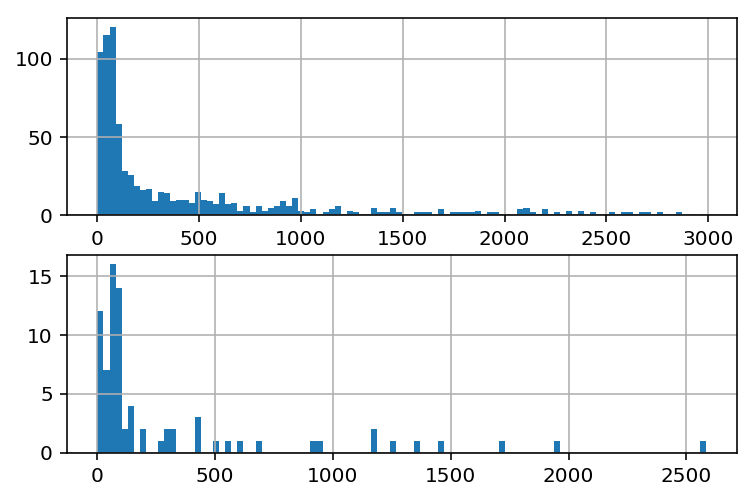

In [21]:
plt.subplot(2, 1, 1)
kahuna_skinny[kahuna_skinny['Pct_Err'] < 3000]['Pct_Err'].hist(bins = 100)

plt.subplot(2, 1, 2)
kahuna_skinny[(kahuna_skinny['Pct_Err'] < 3000) & (kahuna_skinny['A1_FW17'] < 21)]['Pct_Err'].hist(bins = 100)

,A1_FW17,A1_FW18
A1_FW17,1.000000,0.569176
A1_FW18,0.569176,1.000000


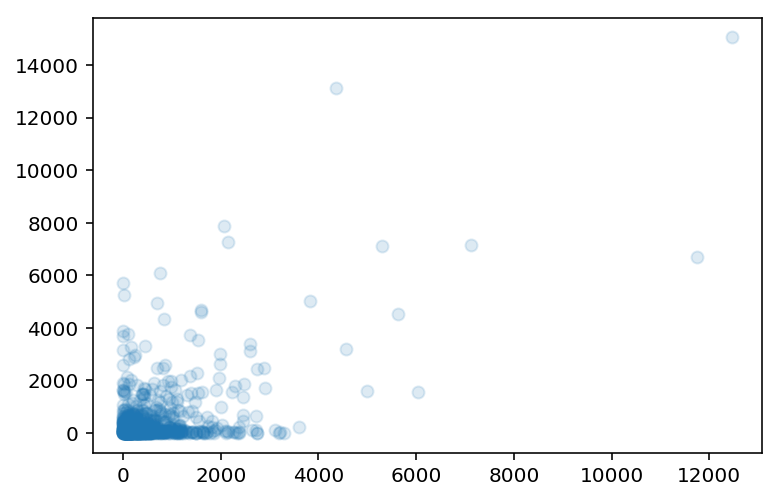

In [22]:
plt.scatter(kahuna_skinny['A1_FW17'], 
            kahuna_skinny['A1_FW18'], 
            # c = dbs01,
            alpha = 0.15)
# plt.xlabel('FW17 net_qty')
# plt.ylabel('Abs Pct Error')

kahuna_skinny[['A1_FW17', 'A1_FW18']].corr()

# plt.rcParams["figure.figsize"] = [16,16]

In [ ]:
# --- Sort by season ---

# order = {'SS17': 0, 'FW17': 1, 'SS18': 2, 'FW18': 3, 'SS19': 4}
# dat['order_id'] = [order[i] for i in dat.reset_index()['season']]

# dat.sort_values(by = ['article_number', 'order_id'], inplace=True)
# dat.drop('order_id', axis = 1, inplace=True)

## 5.2 OLS linear regression

In [ ]:
%%time

dat00 = pd.read_csv('seasonal_sales_indicators.csv', delimiter = '~')

In [ ]:
dat0 = dat00.copy()

dat0.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat0.columns] # tidy column names

dat0.drop(['sales_organization', 'sku', 'total_markdown', 'temporary_markdown', 
           'permanent_markdown', 'employee_markdown', 'fraction_of_full_price', 
           'markdown', 'sale'], inplace=True, axis = 1)

# {print(x, '-->', len(dat0[x].unique())) for x in dat0.columns}
# dat0.dtypes

In [ ]:
dat0 = dat0.groupby(by = ['article_number', 'season']).agg('sum')[['net_qty', 'net_sales']]

# dat0['price'] = dat0['net_sales']/dat0['net_qty']

dat0.reset_index(level = 'season', inplace=True) # convert 'season' back to column

# --- Sort by season ---
# order = {'SS17': 0, 'FW17': 1, 'SS18': 2, 'FW18': 3, 'SS19': 4}
# dat0['order_id'] = [order[i] for i in dat0.reset_index()['season']]

# dat0.sort_values(by = ['article_number', 'order_id'], inplace=True)
# dat0.drop('order_id', axis = 1, inplace=True)

# dat0 = dat0[[s in ['SS17', 'SS19'] for s in dat0['season']]]

dat0 = dat0.replace([np.inf, -np.inf, np.nan], 0)
dat0 = dat0[dat0['net_qty'] > 0]

In [ ]:
dat0

In [ ]:
dat17 = dat0[dat0['season'] == 'SS17']
dat19 = pd.DataFrame(dat0[dat0['season'] == 'SS19']['net_sales'])

dat17_19 = pd.merge(dat17, dat19, left_index = True, right_index=True)
dat17_19

In [ ]:
from sklearn.linear_model import LinearRegression

X = dat17_19.drop(['season', 'net_sales_y'], axis = 1)
y = pd.DataFrame(dat17_19['net_sales_y'])

lin_reg = LinearRegression().fit(X, y)

lin_reg.score(X, y) # R^2 = 0.2706

lin_reg.intercept_
lin_reg.coef_

## 5.3 SARIMAX

In [ ]:
%%time
dat0 = pd.read_csv('seasonal_sales_indicators.csv',
                 delimiter = '~')

# len(dat0['article_number'].unique()) # 46573

In [ ]:
# dat_ref = pd.read_csv('dat_ref.csv', low_memory=False, index_col = 0) 

In [ ]:
dat_ref.head()
dat_ref.shape

In [ ]:
dat = dat0.copy()

dat.columns = [x.replace('t_eu_ecom_dit_dsf_transaction_t.', '') for x in dat.columns] # tidy column names
dat = dat[dat['gross_demand_quantity'] != 0] 
dat['consumer_order_date'] = pd.to_datetime(dat['consumer_order_date'])

dat.head()

In [ ]:
dat.shape

In [ ]:
datter = dat.merge(dat_ref, left_on = 'article_number', right_on = 'group_article', how = 'left')
datter.shape

In [ ]:
datter.head()

In [ ]:
# dat.dtypes

{print(x, '-->', len(dat[x].unique())) for x in dat.columns}

## 5.4 EDA

### 5.4.1

In [ ]:
dat_g = dat.groupby(by = ['article_number', 'consumer_order_date']) # data grouped

dat_aggs = pd.DataFrame(dat_g.agg('sum')['gross_demand_quantity']) # data aggregates

In [ ]:
dat_aggs.reset_index(level = 'article_number', inplace=True)

dat_aggs = dat_aggs.groupby('article_number')
dat_aggs = dat_aggs.resample('W').sum() # 'aggregate' to weekly sums by article

dat_aggs = dat_aggs.reset_index()

# Convert article_number to column, gross_demand_quantity to data
dat_aggs_pivoted = dat_aggs.pivot(index = 'consumer_order_date', 
                                  columns = 'article_number', 
                                  values = 'gross_demand_quantity')

In [ ]:
# dat.fillna(value=0, inplace = True) # Define single transaction article std to be 0
plt.rcParams["figure.figsize"] = [18,6]

dat_aggs_pivoted[dat_aggs_pivoted.columns[0:20]].plot()


In [ ]:
# S21490 (arbitrarily) for learning time series EDA

datS21 = (dat_aggs[dat_aggs['article_number'] == 'S21490'].
          set_index('consumer_order_date').
          drop('article_number', axis = 1)
         )

weekly = datS21.resample('W').sum() # 'aggregate' to weekly sums

weekly.head()
weekly.plot()

### 5.4.2

In [ ]:
dat[dat['season'] == 'FW18']['net_qty'].describe()


In [ ]:
FW18 = dat[dat['season'] == 'FW18']['net_qty']
bins = [0, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 160000]
pd.value_counts(pd.cut(FW18, bins))